# Section 2.1 Xarray, az.InferenceData, and NetCDF for Markov Chain Monte Carlo
_How do we generate, store, and save Markov Chain Monte Carlo results_

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
import pystan
import xarray as xr
np.random.seed(0)

## Learning Objectives
* Understand Markov Chain Monte Carlo fundamentals
* Recognize the meaning of sample, draws and chains in MCMC context
* Understand relationship between Xarray, az.InferenceData, and NetCDF
* Gain profiency with Xarray, NetCDF, and az.InferenceData objects

## Markov Chain Monte Carlo
**Pop quiz**: Why do we use Markov Chain Monte Carlo in Bayesian inferece?

**Highlight for answer:** C<span style="color:white">alculating the posterior distribution is hard</span>!

## Markov Chain Monte Carlo algorithm (greatly simplified)

Step 1: Start at a random spot  
Step 2: Propose a random place to move   
Step 3: Calculate the goodness of proposal  
Step 4: If good place move to proposal, if not good place don't move  
Step 5: Write down where you're standing  
Step 6: Go back to step 2  

** Question for reviewers**
Are samples the accepted proposals only? Or all proposals?
Are draws any proposal, or accepted only?

When animated this algorithm looks like this

In MCMC Step 2 and Step 4 is where most MCMC variants differentiate themselves. Algorithms like Hamiltonian Monte Carlo and Sequential Monte Carlo are better at picking that next step. Richard McElreath has a great visual explainer [on his blog]([http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/)

Chain: A random walk
Sample: A proposal

Regardless of algorithm in MCMC we end up with the same thing, a chain of acceptances from a fixed number of draws

## Markov Chain Monte Carlo with Metropolis Hastings sampler
Below is a working Metropolis Hasting sampler, taken from [Thomas Wiecki's blog](https://twiecki.io/blog/2015/11/10/mcmc-sampling/). For the purposes of this tutorial focus more on the return value, rather than the algorithm details.

It is important to note that this for simplicity's sake we have also hard coded the likelihood and prior in the sampler below. In mathematical notation our model looks like this. We are adding 20 to the estimation of mu to make it easier to recognize the distribution of **parameters** from the distribution of **observed data**

$$
mu \text{~} N(mu\_init, 1) \\
y \text{~} N(mu+20, 1)
$$

In [2]:
def mh_sampler(data, samples=4, mu_init=.5, proposal_width=.5, mu_prior_mu=0, mu_prior_sd=1., offset=20):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = stats.norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = stats.norm(mu_current+offset, 1).logpdf(data).sum()
        likelihood_proposal = stats.norm(mu_proposal+offset, 1).logpdf(data).sum()
        
        # Compute prior probability of current and proposed mu        
        prior_current = stats.norm(mu_prior_mu, mu_prior_sd).logpdf(mu_current)
        prior_proposal = stats.norm(mu_prior_mu, mu_prior_sd).logpdf(mu_proposal)
        
        p_current = likelihood_current + prior_current
        p_proposal = likelihood_proposal + prior_proposal
        
        # Accept proposal?
        p_accept = np.exp(p_proposal - p_current)

        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return np.array(posterior)

## Setup
Before using the sampler let's generate some data to test our Metropolis Hasting Implementation. In the code block below we are generating a bimodal distribution for the sampler. 

In [3]:
data = stats.norm.rvs(loc=30, scale=1, size=1000).flatten()

We'll also plot our samples to get a sense of what the distribution of data looks like. Note how the histogram centers around 30. This should intuitively make sense as we're specified a mean of 30 when generating random values.

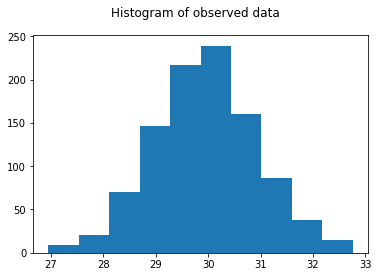

In [4]:
fig, ax = plt.subplots()
ax.hist(data)
fig.suptitle("Histogram of observed data");

As humans we can intuit *data mean* of **30** + an offset of **20** will lead to a parameter mean for *mu* of **10**. We want to see if our inference algorithm can recover our parameters.

## Single Variable Single Chain Inference Run

The simplest MCMC run we can perform is with a single variable and a single chain. We'll do so by putting our sampler function and data to use.

In [5]:
samples = 200
chain = mh_sampler(data=data, samples=samples)
chain[:100]

array([ 0.5       ,  0.77798134,  1.22421828,  1.22421828,  1.2765753 ,
        1.39060196,  1.49134193,  1.76172873,  1.76172873,  1.76172873,
        2.59872158,  2.59872158,  2.59872158,  2.70620438,  2.75481399,
        2.75481399,  2.75481399,  2.75481399,  2.75481399,  2.75481399,
        2.8236589 ,  3.20065464,  3.73331238,  3.93462515,  3.93462515,
        4.23870336,  4.79618452,  5.0139576 ,  5.0139576 ,  5.0139576 ,
        5.0139576 ,  5.0139576 ,  5.5385042 ,  5.5385042 ,  6.17099586,
        6.2759206 ,  6.2759206 ,  6.32510956,  6.51581768,  6.65797494,
        6.86567526,  6.86567526,  6.86567526,  6.90944099,  7.37881443,
        7.37881443,  7.54296508,  7.54296508,  7.54296508,  7.54296508,
        7.54296508,  7.88169616,  7.90760636,  7.90760636,  7.90760636,
        8.27343582,  8.27343582,  8.27343582,  8.27343582,  8.27343582,
        8.27343582,  8.90714165,  9.15689076,  9.50894627,  9.50894627,
        9.50894627,  9.69790133,  9.69790133,  9.69790133,  9.69

And just like that we've performed an inference run! We can generate a traceplot

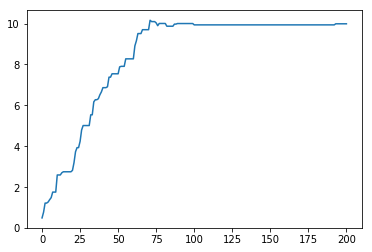

In [6]:
fig, ax = plt.subplots()
x= np.arange(samples+1)
ax.plot(x, chain)

In terms of data structures, for a **single** variable **single** chain inference run, an array suffices for storing samples.

## Single Variable Multiple Chain Inference Run

As Bayesian modelers, life would be relatively easy if a single chain worked well every time, but unfortunately this is not the case. To understand why look at the above inference run. While the sampler started at *mu=8*, it took a 50 or so steps before the sampler honed in on the "correct" value of 10.

MCMC algorithms are sensitive to their starting points and in finite runs it's **not** guaranteed that the Markov Chain will approach the true underlying value. A common method to get around this is to sample from many chains in parallel and see if we get to the same place. We will discuss this further when we get to single model diagnostics.

In [7]:
chain_0 = mh_sampler(data=data, samples=samples)
chain_1 = mh_sampler(data=data, samples=samples, mu_init=13)
data_df = pd.DataFrame({"x_0":chain_0, "x_1":chain_1})

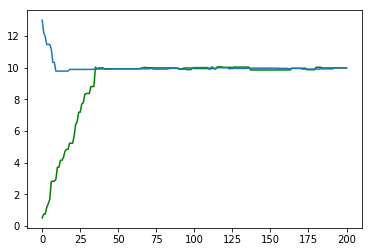

In [8]:
fig, ax = plt.subplots()
x= np.arange(samples+1)
ax.plot(x, data_df["x_0"], c="g")
ax.plot(x, data_df["x_1"])

With two chains converging to approximately a single value we can be more confident that the sampler reached the true underlying parameter. We can also store the results in a 2D data structures, such as Pandas Dataframes in python memory, and csvs or sql tables for persistent on disk storage.

## Multiple Variable Multiple Chain Inference Runs

A Bayesian modelers, life would be relatively easy if all models only had one variable (univariate models in math speak). Unfortunately many types of models require 2 or more variables. For example in a linear regression we are interested in estimating both **m** and **b**

$$ y \text{~} mx+b$$

With at least 3 things to track (chains, samples, and variables) a 2d data structures become limiting. This problem exists in many domains and is the focus of the *xarray* project.

A motivating example comes from climate sciences. In this image from the xarray documentation the researcher might want to measure the temperature and humidity, across a 2D region at a point in time. Or they may want to plot the temperature over a time interval. xarray simplifies the data handling in cases like these.

![XarrayStructure](../../img/dataset-diagram.png)




### Xarray
In ArviZ an xarray DataSet object would look like the one below, where the variables are the Inference run variables, and the coordinates are at a minimum chains, draws.

In [9]:
posterior = xr.Dataset(
        {"mu": (["chain", "draw"], [[11,12,13],[22,23,24]]), "sd": (["chain", "draw"], [[33,34,35],[44,45,46]])},
        coords={"draw": [1,2,3], "chain": [0,1]},
    )
posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 3)
Coordinates:
  * draw     (draw) int64 1 2 3
  * chain    (chain) int64 0 1
Data variables:
    mu       (chain, draw) int64 11 12 13 22 23 24
    sd       (chain, draw) int64 33 34 35 44 45 46

## Multiple Variable Multiple Chain Inference runs and associated datasets
As a Bayesian modelers, life would be relatively easy if we were only concerned about posterior distributions. Looking back at the full end to end workflow, recall that there are other datasets, such as prior predictive samples, posterior predictive samples, among others. To aid the ArviZ user we present az.InferenceData

### az.InferenceData
az.Inference data services as a data container for the various xarray datasets that are generated from an end to end bayesian workflow. Consider our earlier simple model.

This time let's use Stan to run a full analysis with multiple chains, multiple runs, and generate all sorts of datasets common in Bayesian Analysis.

### Calculating prior

In [10]:
stan_code_prior = """
data {
    int<lower=1> N;
}
parameters {
    real mu; // Estimated parameter
}

model {
    mu ~ normal(0, 1);
}
generated quantities {
    real y_hat[N]; // prior prediction
    for (n in 1:N) {
        y_hat[n] = normal_rng(mu+20, 1);
    }
}
"""
stan_prior = pystan.StanModel(model_code=stan_code_prior)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9e2c867eeb58fa5e5ed2bc37cd00496e NOW.


In [11]:
stan_data_prior = {"N" : len(data)}
stan_fit_prior = stan_prior.sampling(data=stan_data_prior)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [12]:
stan_code_posterior = """
data {
    int N;
    real y[N]; // Observed data
}
parameters {
    real mu; // Estimated parameter
}
model {
    mu ~ normal(0, 1);
    y  ~ normal(mu+20, 1);
}
generated quantities {
    real y_hat[N]; // posterior prediction
    real log_lik[N]; // log_likelihood
    
    for (n in 1:N) {
        // Stan normal functions https://mc-stan.org/docs/2_19/functions-reference/normal-distribution.html
        y_hat[n] = normal_rng(mu, 1);
        log_lik[n] = normal_lpdf(y[n] | mu, 1);
    }
}
"""
stan_model_posterior = pystan.StanModel(model_code=stan_code_posterior)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_804203b3f322a673e7cacf6457ff2d3c NOW.


In [13]:
stan_data_posterior = dict(
    y=data,
    N=len(data)
)
stan_fit_posterior = stan_model_posterior.sampling(data=stan_data_posterior)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [14]:
stan_inference_data = az.from_pystan(posterior=stan_fit_posterior,
                       observed_data="y",
                       
                       # Other Bayesian Datasets that we have not discussed yet!
                       posterior_predictive="y_hat", 
                       prior=stan_fit_prior, 
                       prior_predictive="y_hat",
                       log_likelihood="log_lik",
                      )

### NetCDF
Calculating the various datasets may not be is usually not trivial. Network Common Data Form (NetCDF) is an open standard for storing multidimensional datasets like xarray. It even comes with groups support making it easy to serialize az.InferenceData straight to disk. ArviZ utilizes NetCDF to allow "save" the results, share with others.
 
ArviZ even ships with sample datasets, serialized in NetCDF
https://github.com/arviz-devs/arviz/tree/master/arviz/data/_datasets


In short like SQL is to pandas, NetCDF is to az.Inference data.

In [15]:
data = az.load_arviz_data("centered_eight")
data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data

## The benefits of az.InferenceData
One of the goals for the ArviZ developers is to ensure that Bayesian practioners can share and reproduce analyses regardless of PPl, regardless of language and az.InferenceData was the implementation of this idea.

In summary az.InferenceData 
* provides a consistent format for Bayesian Datasets.
* makes it easy to save results
* makes use of ArviZ plotting and statistics functions simpler
* stores metadata for ease of reproducibility

## InferenceData in practice
In practice it's rare to ever generate a xarray manually for use in ArviZ. Instead ArviZ provides methods for instatiating InferenceData from plain python objects, mappings to various PPLs, as well as methods to save and load NetCDF files.

For further references consider the ArviZ cookbook, and data structure tutorial.
https://arviz-devs.github.io/arviz/notebooks/InferenceDataCookbook.html
https://arviz-devs.github.io/arviz/notebooks/XarrayforArviZ.html

## Examples
See below for some useful methods of interacting with az.InferenceData, Xarray, and NetCDF

For Xarray methods we only demo a subset of the available api. For a much more comprehensive explanation view the indexing and selection page from the xarray docs
http://xarray.pydata.org/en/stable/indexing.html

### Creating InferenceData objects
We can create an InferenceData objects from our "home built" chain, not just from the output of supported PPLs

In [16]:
data_dict = {"mu": [chain_0, chain_1]}
home_built_data = az.from_dict(data_dict)
home_built_data

Inference data with groups:
	> posterior

In [17]:
# Load NetCDF from disk into memory
## Replace with NetCDF that's "visible"
data = az.load_arviz_data("centered_eight")

In [18]:
# Reference posterior directly
posterior = data.posterior
posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 500, school: 8)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * school   (school) object 'Choate' 'Deerfield' ... "St. Paul's" 'Mt. Hermon'
Data variables:
    mu       (chain, draw) float64 ...
    theta    (chain, draw, school) float64 ...
    tau      (chain, draw) float64 ...
Attributes:
    created_at:                 2018-10-03T14:26:54.822913
    inference_library:          pymc3
    inference_library_version:  3.5

In [19]:
# Select specific variables
posterior[["mu", "tau"]]

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 500)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Data variables:
    mu       (chain, draw) float64 ...
    tau      (chain, draw) float64 ...
Attributes:
    created_at:                 2018-10-03T14:26:54.822913
    inference_library:          pymc3
    inference_library_version:  3.5

In [20]:
# Select specific chains and draws
posterior.sel(chain=[0,2], draw=slice(0,5))

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 6, school: 8)
Coordinates:
  * chain    (chain) int64 0 2
  * draw     (draw) int64 0 1 2 3 4 5
  * school   (school) object 'Choate' 'Deerfield' ... "St. Paul's" 'Mt. Hermon'
Data variables:
    mu       (chain, draw) float64 ...
    theta    (chain, draw, school) float64 ...
    tau      (chain, draw) float64 ...
Attributes:
    created_at:                 2018-10-03T14:26:54.822913
    inference_library:          pymc3
    inference_library_version:  3.5

In [21]:
# Get first 10 samples of mu from chain 0
posterior["mu"].sel(chain=0, draw=slice(0,10)).values

array([ 5.12405692,  5.00228516,  4.31923729,  5.96001625,  1.26754626,
        7.96140002,  8.59824918,  4.79273969,  1.77511138, -0.28240422,
       -0.7803849 ])

## Extra Credit
* xarray supports numpy ufuncs https://docs.scipy.org/doc/numpy/reference/ufuncs.html. ArviZ uses these under the hood for efficient calculations. 